# Graph Learning
## Lab 5: Heat Diffusion

In this lab, you will learn to use heat diffusion for **contrastive ranking** and **node classification**.

## Import

In [362]:
from IPython.display import SVG

In [363]:
import numpy as np
from scipy import sparse

In [364]:
from sknetwork.data import load_netset, grid, karate_club
from sknetwork.regression import Dirichlet
from sknetwork.classification import DiffusionClassifier
from sknetwork.ranking import PageRank
from sknetwork.utils import directed2undirected
from sknetwork.visualization import visualize_graph
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph + bipartite graph)

In [365]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Grid

We first illustrate the notion of **contrastive ranking** on a $k\times k$ grid.

In [366]:
k = 5
datasetGrid = grid(k, k, True)
adjacencyGrid = datasetGrid.adjacency
positionGrid = datasetGrid.position

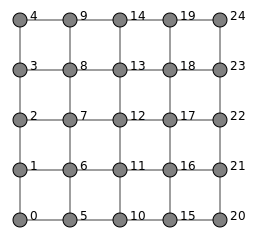

In [367]:
image = visualize_graph(adjacencyGrid, positionGrid, names=np.arange(k * k), width=200, height=200)
SVG(image)

## To do

* Display the solution to the Dirichlet problem with 1 hot source and 1 cold source, located on the opposite corners of the square.
* Add a hot source at the top-left corner of the square. What is the free node of highest temperature?

In [368]:
dirichlet = Dirichlet()

In [369]:
bottom_left = 0
top_right = k * k - 1

In [370]:
values = {bottom_left: 0, top_right: 1}

In [371]:
temperatures = dirichlet.fit_predict(adjacencyGrid, values=values)

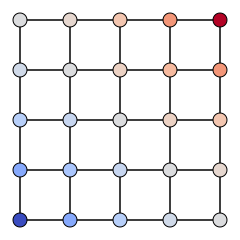

In [372]:
image = visualize_graph(adjacencyGrid, positionGrid, scores=temperatures, width=200, height=200)
SVG(image)

In [373]:
# add hot source
top_left = k-1
values[top_left] = 1
temperatures = dirichlet.fit_predict(adjacencyGrid, values=values)

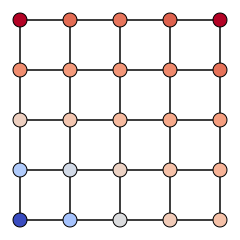

In [374]:
image = visualize_graph(adjacencyGrid, positionGrid, scores=temperatures, width=200, height=200)
SVG(image)

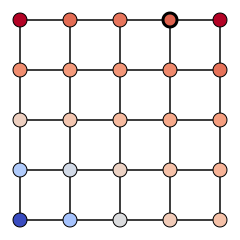

In [375]:
# find free node with highest temperature
mask = np.ones(k * k, dtype=bool)   # mask of nodes
mask[list(values)] = 0              # only free nodes in mask
i = np.argmax(temperatures[mask])   # hottest free node
hot = np.flatnonzero(mask)[i]

image = visualize_graph(adjacencyGrid, positionGrid, scores=temperatures, seeds=hot, width=200, height=200)
SVG(image)

## Karate Club


We now consider the **classification** of nodes by heat diffusion. We use the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) that has ground-truth labels.

In [376]:
datasetKC = karate_club(True)

In [377]:
adjacencyKC = datasetKC.adjacency
positionKC = datasetKC.position
labels_true_KC = datasetKC.labels

In [378]:
n = len(labels_true_KC)

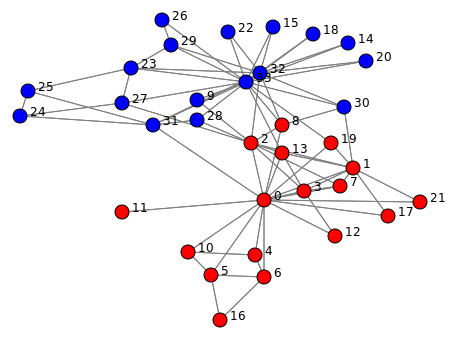

In [379]:
image = visualize_graph(adjacencyKC, positionKC, labels=labels_true_KC, names=np.arange(n))
SVG(image)

## To do

* Select one node in each ground-truth cluster, and predict the labels of the other nodes by heat diffusion.
* Display the graph with the predicted labels. 
* What is the accuracy of the classification?

In [380]:
classifier = DiffusionClassifier()

In [381]:
labels = labels_true_KC.copy()
seeds = np.array([16, 26])
mask = np.zeros(len(labels), dtype=bool)
mask[seeds] = 1
labels[~mask] = -1

In [382]:
labels_pred = classifier.fit_predict(adjacencyKC, labels)

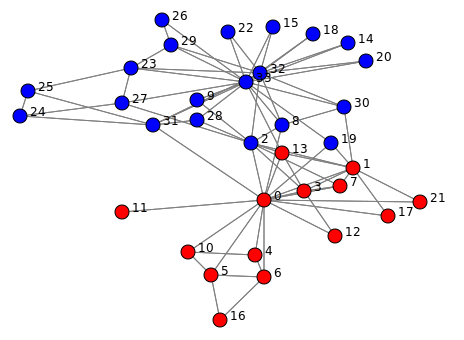

In [383]:
image = visualize_graph(adjacencyKC, positionKC, labels=labels_pred, names=np.arange(len(labels_true_KC)))
SVG(image)

In [384]:
# accuracy
print(np.mean(labels_pred == labels_true_KC))

0.9117647058823529


## To do

The classifier applies temperature centering after diffusion.

* Repeat the same experiment without temperature centering.
* Do the same experiments with 3 nodes in a ground-truth cluster and 1 in the other.
* Comment the results.

In [385]:
classifier = DiffusionClassifier(centering=False)

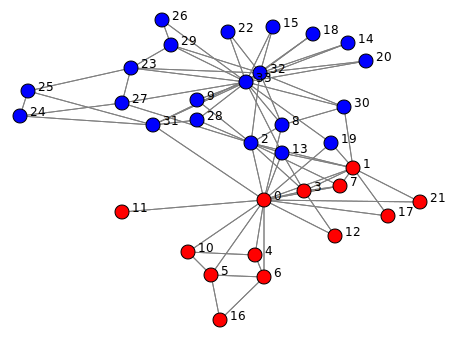

In [386]:
labels_pred = classifier.fit_predict(adjacencyKC, labels)

image = visualize_graph(adjacencyKC, positionKC, labels=labels_pred, names=np.arange(len(labels_true_KC)))
SVG(image)

In [387]:
# accuracy
print(np.mean(labels_pred == labels_true_KC))

0.8823529411764706


In [388]:
# new training - 3 nodes vs 1 node
labels = labels_true_KC.copy()
seeds = np.array([0, 10, 16, 26])
mask = np.zeros(len(labels), dtype=bool)
mask[seeds] = 1
labels[~mask] = -1

In [389]:
labels_pred = classifier.fit_predict(adjacencyKC, labels)
print(np.mean(labels_true_KC == labels_pred)) # accuracy

0.5588235294117647


<div style="border: 1px solid white; padding: 10px; display: inline-block; max-width: 98%; box-sizing: border-box; word-wrap: break-word;">
  <strong>Answer</strong>
  <br> Without centering, the classification is biased towards the class with more seeds, thus decreasing the accuracy in comparison to the previous training. We can see below that with the same nodes, but using centering, we can increase the accuracy again.
</div> 

In [390]:
classifier = DiffusionClassifier(centering=True)
labels_pred = classifier.fit_predict(adjacencyKC, labels)
print(np.mean(labels_pred == labels_true_KC))

0.9705882352941176


## Openflights


We now show how to classify the nodes of a graph **without labels**. We identify some nodes of interest and use these seeds to classify the other nodes.

In [391]:
datasetOF = openflights

In [392]:
adjacencyOF = datasetOF.adjacency
positionOF = datasetOF.position
namesOF = datasetOF.names

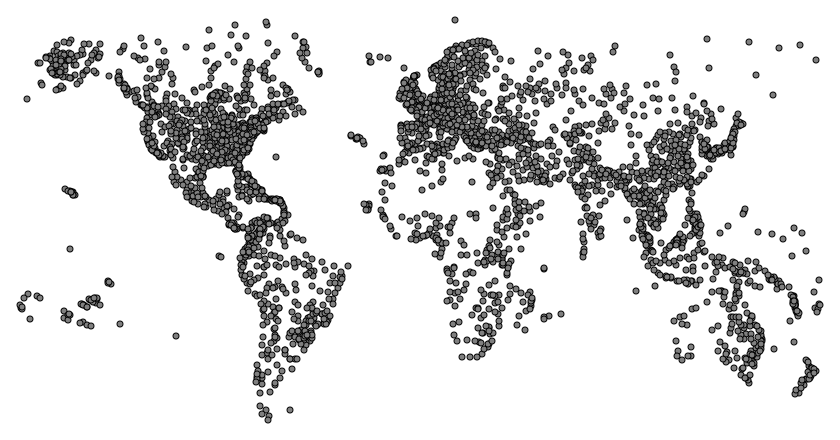

In [393]:
image = visualize_graph(adjacencyOF, positionOF, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with the labels predicted for 3 seeds (Paris, New-York, Beijing), each with its own  label.
* Add Madrid with another label and comment the results.

In [394]:
paris = 622
newyork = 1842
beijing = 1618
madrid = 572

In [395]:
classifier = DiffusionClassifier()

labelsOF = {paris: 0, newyork: 1, beijing: 2}
labels_pred = classifier.fit_predict(adjacencyOF, labelsOF)

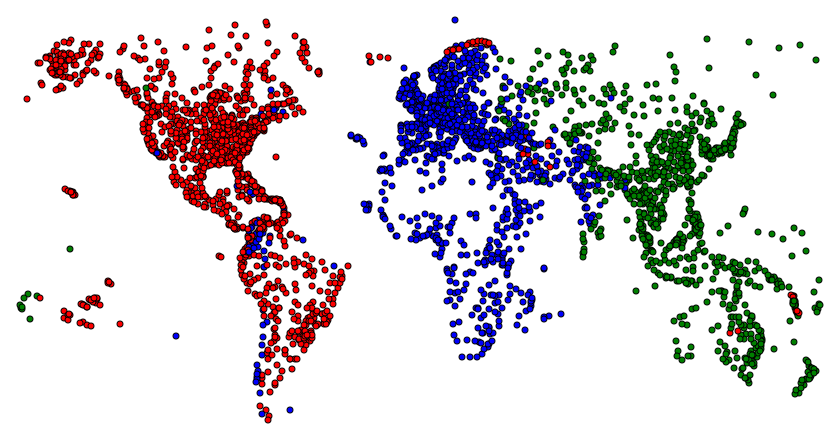

In [396]:
image = visualize_graph(adjacencyOF, positionOF, width=800, height=400, node_size=3, labels=labels_pred, display_edges=False)
SVG(image)

In [397]:
labelsOF[madrid] = 3
labels_pred = classifier.fit_predict(adjacencyOF, labelsOF)

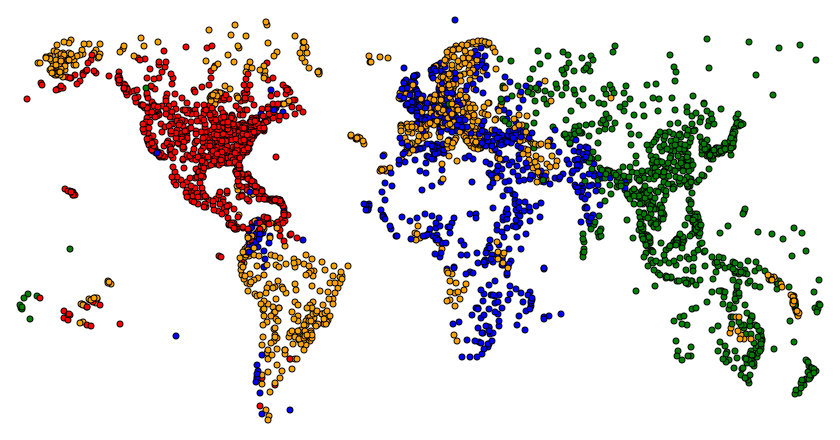

In [398]:
image = visualize_graph(adjacencyOF, positionOF, width=800, height=400, node_size=3, labels=labels_pred, display_edges=False)
SVG(image)

<div style="border: 1px solid white; padding: 10px; display: inline-block; max-width: 98%; box-sizing: border-box; word-wrap: break-word;">
  <strong>Answer</strong>
  <br> Adding Madrid as a fourth seed with its own label creates a more balanced classification in Europe. Since Madrid is geographically close to Paris, it competes for influence over European airports, leading to a more refined clustering that better reflects regional airline connectivity patterns.
</div>

Finally, we illustrate **contrastive ranking** on Openflights.

**-- REFAZER --**  
A celula abaixo é o que o gpt fez, parece bem errado e no 2o item da prox to do list fala pra usar constrative ranking tbm mas de outro jeito

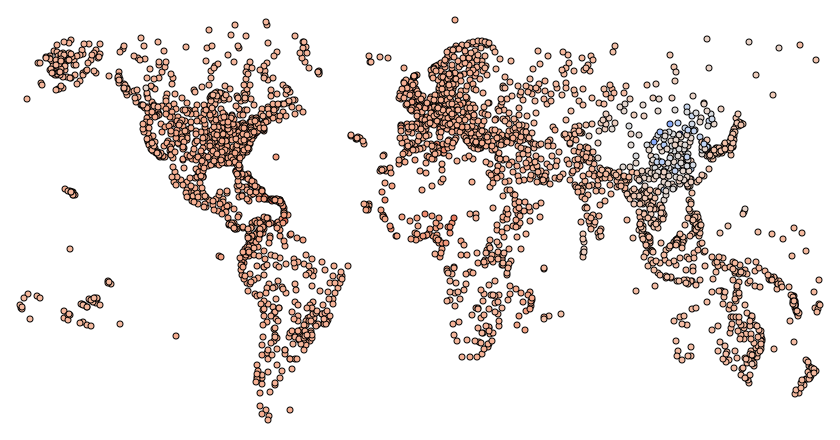

In [399]:
# Contrastive ranking using Dirichlet problem
dirichlet = Dirichlet()

values = {paris: 1, newyork: 1, beijing: 0}
contrastive_scores = dirichlet.fit_predict(adjacencyOF, values)

# Visualize contrastive ranking
image = visualize_graph(adjacencyOF, positionOF, scores=contrastive_scores, 
                       node_size=3, width=800, height=400, display_edges=False)
SVG(image)


## To do

* List the top-10 airports that are the closest to Tokyo in terms of Personalized PageRank.
* List of the top-10 airports that are both the closest to Tokyo and the furthest from Paris Charles de Gaulle, using heat diffusion (contrastive ranking).<br>What do you observe?
* Give the temperatures of these airports after heat diffusion and explain the result.

In [400]:
tokyo = 1084

In [401]:
# 10 closest to tokyo
pagerank = PageRank()
scores_pos = pagerank.fit_predict(adjacencyOF, weights={tokyo: 1})
top_pagerank = np.argsort(-scores_pos)[:10]
print(namesOF[top_pagerank])

['Tokyo Haneda International Airport' 'Incheon International Airport'
 'Naha Airport' 'Taiwan Taoyuan International Airport'
 'Osaka International Airport' 'Shanghai Pudong International Airport'
 'New Chitose Airport' 'Kansai International Airport'
 'Narita International Airport' 'Chubu Centrair International Airport']


In [402]:
# tokyo vs paris
dirichlet = Dirichlet()
values = {paris: 0, tokyo: 1}
scores_pos = dirichlet.fit_predict(adjacencyOF, values)
top_diffusion = np.argsort(-scores_pos)[:10]
print(namesOF[top_diffusion])

['Kitakyūshū Airport' 'Tokushima Airport' 'Tokachi-Obihiro Airport'
 'Oshima Airport' 'Tokyo Haneda International Airport' 'Tottori Airport'
 'Hachijojima Airport' 'Izumo Airport' 'Monbetsu Airport' 'Shonai Airport']


<div style="border: 1px solid white; padding: 10px; display: inline-block; max-width: 98%; box-sizing: border-box; word-wrap: break-word;">
  <strong>Answer:
</strong>
  <br> The top airports are predominantly located in Asia and the Pacific region. This makes sense because heat diffusion with contrastive sources (Tokyo=1, Paris=0) identifies airports that are well-connected to Tokyo through the flight network while being poorly connected to Paris. The results show a clear geographical clustering effect based on airline connectivity patterns.
</div>

In [403]:
for i, idx in enumerate(top_diffusion):
    name = namesOF[idx]
    temp = scores_pos[idx]
    print(f"{i+1}. {name}: temperature = {temp:.4f}")

1. Kitakyūshū Airport: temperature = 1.0000
2. Tokushima Airport: temperature = 1.0000
3. Tokachi-Obihiro Airport: temperature = 1.0000
4. Oshima Airport: temperature = 1.0000
5. Tokyo Haneda International Airport: temperature = 1.0000
6. Tottori Airport: temperature = 1.0000
7. Hachijojima Airport: temperature = 1.0000
8. Izumo Airport: temperature = 1.0000
9. Monbetsu Airport: temperature = 1.0000
10. Shonai Airport: temperature = 1.0000


<div style="border: 1px solid white; padding: 10px; display: inline-block; max-width: 98%; box-sizing: border-box; word-wrap: break-word;">
  <strong>Answer:</strong>
  <br> The temperatures are equal to 1.0 for all top-10 airports because these airports are only connected to Tokyo in the flight network, not to Paris. In the Dirichlet problem with Tokyo=1 (hot) and Paris=0 (cold), airports that have flight connections only to Tokyo will maintain the full temperature of 1.0, as there's no "cooling" effect from Paris reaching them through the network.
</div>

## Wikipedia Vitals

We now consider the graph of links of WikiVitals, considered as undirected. We first focus on **constrastive ranking**, then on **node classification**.

In [404]:
datasetWV = wikivitals

In [405]:
adjacencyWV = datasetWV.adjacency
namesWV = datasetWV.names
labelsWV = datasetWV.labels
names_labels_WV = datasetWV.names_labels

In [406]:
adjacency = directed2undirected(adjacencyWV)

## Contrastive ranking

## To do

* List the top-10 articles that are close to **Cat** and **Dog** in terms of Personalized PageRank.
* Compare with the list of top-10 articles that are close to **Cat** and **Dog** and far from **Bear** and **Tiger** using heat diffusion (contrastive ranking).
* List the top-10 articles that are close to **Bear** and **Tiger** and far from **Cat** and **Dog** (you can use previous diffusion). Interpret the results.

In [407]:
pagerank = PageRank()

In [408]:
pagerank.fit(adjacency, force_bipartite=True)

PageRank(damping_factor=0.85, solver='piteration', n_iter=10, tol=1e-06)

In [409]:
# Top 10 scores for cat and dog

dog_index = [i for i, name in enumerate(namesWV) if 'dog' == name.lower()]
cat_index = [i for i, name in enumerate(namesWV) if 'cat' == name.lower()]
print(f"Index: {dog_index}, Name: {namesWV[dog_index]}")
print(f"Index: {cat_index}, Name: {namesWV[cat_index]}")

cd_perso_scores = pagerank.fit_predict(adjacencyWV, {dog_index[0]: 1, cat_index[0]: 1})
ranked_indices_cd = np.argsort(cd_perso_scores)[-10:][::-1]

print("\n Top 10 closest articles to cat and dog\n")
for rank, i in enumerate(ranked_indices_cd, 1):
    print(f"{rank}. {datasetWV.names[i]} (score: {cd_perso_scores[i]:.4f})")

Index: [2468], Name: ['Dog']
Index: [1497], Name: ['Cat']

 Top 10 closest articles to cat and dog

1. Dog (score: 0.0767)
2. Cat (score: 0.0765)
3. Taxonomy (biology) (score: 0.0030)
4. Animal (score: 0.0029)
5. Mammal (score: 0.0026)
6. Chordate (score: 0.0024)
7. Latin (score: 0.0024)
8. Carl Linnaeus (score: 0.0020)
9. World War II (score: 0.0020)
10. Carnivora (score: 0.0020)


In [410]:
# Top 10 scores for cat and dog and far from bear and tiger

diffusionWV = Dirichlet()

bear_index = [i for i, name in enumerate(namesWV) if 'bear' == name.lower()]
tiger_index = [i for i, name in enumerate(namesWV) if 'tiger' == name.lower()]

print(f"Index: {bear_index}, Name: {namesWV[bear_index]}")
print(f"Index: {tiger_index}, Name: {namesWV[tiger_index]}")

bt_perso_scores = diffusionWV.fit_predict(adjacencyWV,
                                            {dog_index[0]: 1,
                                            cat_index[0]: 1,
                                            bear_index[0]: 0,
                                            tiger_index[0]: 0})

ranked_indices_cd = np.argsort(bt_perso_scores)[-10:][::-1]

print("\n Top 10 closest articles to cat and dog and far from bear and tiger\n")
for rank, i in enumerate(ranked_indices_cd, 1):
    print(f"{rank}. {datasetWV.names[i]} (score: {bt_perso_scores[i]:.4f})")

Index: [963], Name: ['Bear']
Index: [9126], Name: ['Tiger']

 Top 10 closest articles to cat and dog and far from bear and tiger

1. Cat (score: 1.0000)
2. Dog (score: 1.0000)
3. Terrier (score: 0.6790)
4. Retriever (score: 0.5434)
5. Great Dane (score: 0.5367)
6. Mouse (score: 0.5350)
7. Moulting (score: 0.5328)
8. Skink (score: 0.5320)
9. Lyrebird (score: 0.5278)
10. Budgerigar (score: 0.5270)


In [411]:
# Top 10 scores for bear and tiger and far from cat and dog

ranked_indices_cd = np.argsort(-bt_perso_scores)[-10:][::-1]

print("\n Top 10 closest articles to bear and tiger and far from cat and dog\n")
for rank, i in enumerate(ranked_indices_cd, 1):
    print(f"{rank}. {datasetWV.names[i]} (score: {bt_perso_scores[i]:.4f})")


 Top 10 closest articles to bear and tiger and far from cat and dog

1. Bear (score: 0.0000)
2. Gloss (optics) (score: 0.0000)
3. Goby (score: 0.0000)
4. Tiger (score: 0.0000)
5. Serranidae (score: 0.4603)
6. Endangered species (score: 0.4727)
7. Hibernation (score: 0.4745)
8. Malay Peninsula (score: 0.4777)
9. Taxidermy (score: 0.4819)
10. Legendary creature (score: 0.4849)


<div style="border: 1px solid white; padding: 10px; display: inline-block; max-width: 98%; box-sizing: border-box; word-wrap: break-word;">
  <strong>Answer:</strong>
  <br> The articles closest to Bear/Tiger and far from Cat/Dog are likely related to wild animals, nature, and wildlife. This contrastive ranking successfully separates domestic animals (cats/dogs) from wild animals (bears/tigers), showing that the Wikipedia link structure captures semantic relationships between articles about different types of animals.
  
</div>

## Node classification

We now use the ground-truth labels provided by the category of each article.

In [412]:
print(names_labels_WV)

['Arts' 'Biological and health sciences' 'Everyday life' 'Geography'
 'History' 'Mathematics' 'People' 'Philosophy and religion'
 'Physical sciences' 'Society and social sciences' 'Technology']


## To do

* What is the accuracy of node classification, using half of the nodes in the train set?
* Display the confusion matrix. What is the most difficult class to predict?
* Give examples of misclassification for each label (e.g., 2 false positives and 2 false negatives per label).

Accuracy: 0.6936


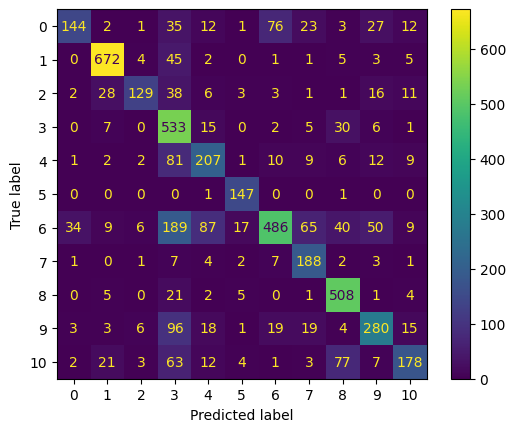

In [413]:
from sklearn import metrics
from matplotlib import pyplot as plt

num_nodes = adjacencyWV.shape[0]
full_labels = -1 * np.ones(num_nodes, dtype=int)
indices = np.arange(num_nodes)
train_idx, test_idx = train_test_split(
    indices, test_size=0.5, stratify=labelsWV
)

full_labels[train_idx] = labelsWV[train_idx]

diff_clf = DiffusionClassifier()
diff_clf.fit(adjacencyWV, full_labels)

y_pred = diff_clf.predict()[test_idx]

labels_unique = np.unique(labelsWV[test_idx])

print(f"Accuracy: {accuracy_score(labelsWV[test_idx], y_pred):.4f}")

confusion_matrix = metrics.confusion_matrix(labelsWV[test_idx], y_pred, labels=labels_unique)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels_unique)

cm_display.plot()
plt.show()

Accuracy: 0.7473


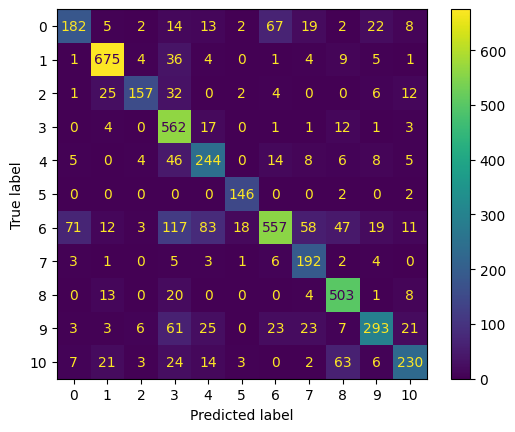

In [414]:
from sklearn import metrics
from matplotlib import pyplot as plt

num_nodes = adjacency.shape[0]
full_labels = -1 * np.ones(num_nodes, dtype=int)
indices = np.arange(num_nodes)
train_idx, test_idx = train_test_split(
    indices, test_size=0.5, stratify=labelsWV
)

full_labels[train_idx] = labelsWV[train_idx]

diff_clf = DiffusionClassifier()
diff_clf.fit(adjacency, full_labels)

# Faz predição apenas para os nós de teste
y_pred = diff_clf.predict()[test_idx]

print(f"Accuracy: {accuracy_score(labelsWV[test_idx], y_pred):.4f}")

confusion_matrix = metrics.confusion_matrix(labelsWV[test_idx], y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

<div style="border: 1px solid white; padding: 10px; display: inline-block; max-width: 98%; box-sizing: border-box; word-wrap: break-word;">
  <strong>Answer</strong>
  <br>Looking at the confusion matrix, the most difficult classes to predict appears to be “Everyday Life” and “History”. This is probably due to the fact that they are semantically similar to other categories, causing confusion in the dissemination process.
  
</div>

In [415]:
true = labelsWV[test_idx]
pred = y_pred

# Obter todas as classes únicas
labels = np.unique(true)

false_positives = {label: [] for label in labels}
false_negatives = {label: [] for label in labels}

for i, (t, p, idx) in enumerate(zip(true, pred, test_idx)):
    if t != p:
        false_negatives[t].append(idx)
        false_positives[p].append(idx)

for label, i in enumerate(labels,0):
    fp_examples = false_positives[label][:2]
    fn_examples = false_negatives[label][:2]

    fp_names = [namesWV[i] for i in fp_examples]
    fn_names = [namesWV[i] for i in fn_examples]

    print(f"\nLabel {names_labels_WV[i]}:")
    print(f"  False Positives (predicted as {names_labels_WV[i]} but shouldn't be): {fp_names}")
    print(f"  False Negatives (should be {names_labels_WV[i]} but predicted otherwise): {fn_names}")


Label Arts:
  False Positives (predicted as Arts but shouldn't be): ['Carl Theodor Dreyer', 'Zombie']
  False Negatives (should be Arts but predicted otherwise): ['Oxford English Dictionary', 'The Birth of a Nation']

Label Biological and health sciences:
  False Positives (predicted as Biological and health sciences but shouldn't be): ['Oxford English Dictionary', 'Ultrasound']
  False Negatives (should be Biological and health sciences but predicted otherwise): ['Friesian horse', 'Mango']

Label Everyday life:
  False Positives (predicted as Everyday life but shouldn't be): ['Club (organization)', 'Peanuts']
  False Negatives (should be Everyday life but predicted otherwise): ['Rugby World Cup', 'Roulette']

Label Geography:
  False Positives (predicted as Geography but shouldn't be): ['Mediterranean and Middle East theatre of World War II', 'Kurds']
  False Negatives (should be Geography but predicted otherwise): ["Tassili n'Ajjer", 'Longitude']

Label History:
  False Positives (p

## To do

* Classify each article of the **People** category in one of the other categories (Mathematics, History, etc.), using all other labels.
* List the top-5 predicted people of each category using Personalized PageRank.

In [416]:
people_label = 6
people_mask = (labelsWV == people_label)

# Cria labels com -1 para People, para o treino
labels_for_training = labelsWV.copy()
labels_for_training[people_mask] = -1

labels_pred = diff_clf.fit_predict(adjacency, labels_for_training)

people_indices = np.where(people_mask)[0]
people_labels_pred = labels_pred[people_indices]

In [417]:

for label in np.unique(labelsWV):
    if label == people_label:
        continue

    mask = (labels_pred == label) & (labelsWV == people_label)
    if np.sum(mask) == 0:
        continue

    pagerank = PageRank()
    scores = pagerank.fit_predict(adjacency, mask, force_bipartite=True)
    scores *= mask

    top_indices = np.argsort(-scores)[:5]

    print(f"{names_labels_WV[label]}")
    for i in top_indices:
        print(f"  - {namesWV[i]} (score: {scores[i]:.4f})")
    print('---')



Arts
  - Bob Dylan (score: 0.0009)
  - Fred Astaire (score: 0.0008)
  - Barbra Streisand (score: 0.0008)
  - Judy Garland (score: 0.0008)
  - Orson Welles (score: 0.0008)
---
Biological and health sciences
  - Charles Darwin (score: 0.0049)
  - Konrad Lorenz (score: 0.0049)
  - Carl Linnaeus (score: 0.0049)
  - Francis Crick (score: 0.0049)
  - Antonie van Leeuwenhoek (score: 0.0049)
---
Everyday life
  - LeBron James (score: 0.0079)
  - Willie Mays (score: 0.0078)
  - Jackie Robinson (score: 0.0078)
  - Wayne Gretzky (score: 0.0078)
  - Babe Ruth (score: 0.0076)
---
Geography
  - Carl Lewis (score: 0.0007)
  - Martina Navratilova (score: 0.0007)
  - Muhammad Ali (score: 0.0007)
  - Steffi Graf (score: 0.0007)
  - Pelé (score: 0.0007)
---
History
  - Alexander the Great (score: 0.0008)
  - Napoleon (score: 0.0007)
  - Charlemagne (score: 0.0006)
  - Winston Churchill (score: 0.0006)
  - Augustus (score: 0.0006)
---
Mathematics
  - Leonhard Euler (score: 0.0043)
  - Archimedes (score: 0

## 2. Bipartite graphs

Finally, we consider the bipartite graph between articles and words in WikiVitals.

In [418]:
datasetWV = wikivitals
biadjacency = datasetWV.biadjacency

In [419]:
words = datasetWV.names_col

## To do

* Repeat the experiments on node classification using the bipartite graph between articles and words.
* Which information seems to be richer, the text or the links between articles?
* Propose a solution exploiting both sources of information.


Accuracy for bipartite graph: 0.8074


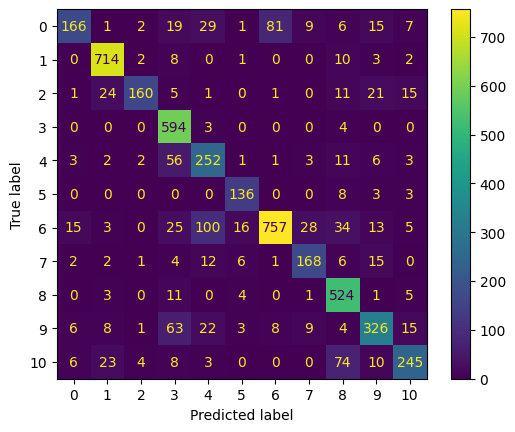

In [420]:
from sklearn import metrics
from matplotlib import pyplot as plt

num_nodes = biadjacency.shape[0]
full_labels = -1 * np.ones(num_nodes, dtype=int)
indices = np.arange(num_nodes)
train_idx, test_idx = train_test_split(
    indices, test_size=0.5, stratify=labelsWV
)

full_labels[train_idx] = labelsWV[train_idx]

diff_clf = DiffusionClassifier()
diff_clf.fit(biadjacency, full_labels)

bi_y_pred = diff_clf.predict()[test_idx]

print(f"\nAccuracy for bipartite graph: {accuracy_score(labelsWV[test_idx], bi_y_pred):.4f}")

confusion_matrix = metrics.confusion_matrix(labelsWV[test_idx], bi_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

<div style="border: 1px solid white; padding: 10px; display: inline-block; max-width: 98%; box-sizing: border-box; word-wrap: break-word;">
  <strong>Answer:</strong>
  <br> 
  Comparing the accuracy scores, the text information (bipartite graph with words) appears to be richer than the link information between articles. This suggests that the words contained in articles provide more discriminative features for classification than the hyperlink structure. 
</div>

In [421]:
full_matrix = sparse.hstack((adjacency, biadjacency))

classifier_combined = DiffusionClassifier()
labels_pred = classifier_combined.fit_predict(full_matrix, full_labels)
comb_y_pred = diff_clf.predict()[test_idx]

acc_combined = accuracy_score(labelsWV[test_idx], comb_y_pred)

print(f"Accuracy using concatenated approach: {acc_combined:.4f}")

Accuracy using concatenated approach: 0.8074


<div style="border: 1px solid white; padding: 10px; display: inline-block; max-width: 98%; box-sizing: border-box; word-wrap: break-word;">
  This approach combines structural and textual information by horizontally stacking the article-article adjacency matrix with the article-word biadjacency matrix to create a unified graph. By applying the DiffusionClassifier on this extended graph, label information propagates through both article connections (capturing structural similarity) and shared word usage (capturing semantic similarity). This hybrid approach enables the model to leverage both network topology and content features simultaneously, often leading to improved classification performance compared to using either source alone.
</div>
